In [3]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#loading data (UCI Machine Learning - Online Retail)

path="data/Online_Retail.xlsx"
df=pd.read_excel(path, engine="openpyxl", parse_dates=["InvoiceDate"])
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [36]:
#Creating table RFM (Reference, Frecuency, Value)

# TotalSum Column
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# Lastday column
import datetime
snapshot_date = max(df.InvoiceDate) + datetime.timedelta(days=1)

# Add values for column
customers = df.groupby(['CustomerID']).agg({
'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
'InvoiceNo': 'count',
'TotalSum': 'sum'})

# Renombramos las columnas
customers.rename(columns = {'InvoiceDate': 'days_pass',
'InvoiceNo': 'Frecuency',
'TotalSum': 'Value'}, inplace=True)

In [60]:
customers

,days_pass,Frecuency,Value
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


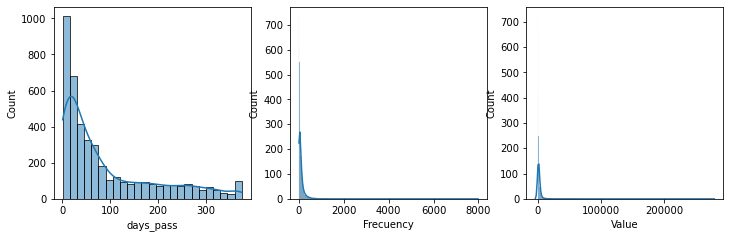

In [15]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
for i, column in enumerate(customers.columns, 1):
    plt.subplot(3,3,i)
    sns.histplot(customers[column],kde=True)    

In [38]:
# Box-Cox Transform
from sklearn.preprocessing import PowerTransformer
# extract features with skew
features=customers[["days_pass","Frecuency"]]

#instatiate 
pt=PowerTransformer(method="box-cox",standardize=True)
#Fit the data to the powertransformer
skl_boxcox=pt.fit(features)

#Transform the data 
skl_boxcox=pt.transform(features)

#Pass the transformed data into a new dataframe 
df_features=pd.DataFrame(data=skl_boxcox,columns=["days_pass_BC","Frecuency_BC"])
#df_features

[0.17079805 0.057133  ]


In [48]:
#Repeat with log and sqrt
df_features["days_pass_log"]=pd.Series(np.log(customers["days_pass"])).values
df_features["days_pass_sqrt"]=pd.Series(np.sqrt(customers["days_pass"])).values

df_features["Frecuency_log"]=pd.Series(np.log(customers["Frecuency"])).values
df_features["Frecuency_sqrt"]=pd.Series(np.sqrt(customers["Frecuency"])).values


column_to_move = df_features.pop("Frecuency_BC")
df_features.insert(3, "Frecuency_BC", column_to_move)

In [49]:
df_features

,days_pass_BC,days_pass_log,days_pass_sqrt,Frecuency_BC,Frecuency_log,Frecuency_sqrt
0,1.611173,5.786897,18.055470,-2.098072,0.693147,1.414214
1,-1.797592,0.693147,1.414214,1.151346,5.204007,13.490738
2,0.309053,4.317488,8.660254,-0.224316,3.433987,5.567764
3,-0.645121,2.944439,4.358899,0.423978,4.290459,8.544004
4,1.560964,5.736572,17.606817,-0.660498,2.833213,4.123106
...,...,...,...,...,...,...
4367,1.453730,5.627621,16.673332,-1.033496,2.302585,3.162278
4368,1.050255,5.198497,13.453624,-1.277936,1.945910,2.645751
4369,-1.140972,2.079442,2.828427,-0.850484,2.564949,3.605551
4370,-1.488693,1.386294,2.000000,2.363661,6.628041,27.495454


In [50]:
#skew without transformation
print(customers.skew())
#skew with transformation
print(df_features.skew())

#we consider simetric when skew is close to zero, in days_pass and Frecuency the best fit if or box_cox transformation.

days_pass     1.249665
Frecuency    18.153735
Value        21.705287
dtype: float64
days_pass_BC     -0.073259
days_pass_log    -0.534991
days_pass_sqrt    0.592223
Frecuency_BC      0.004669
Frecuency_log    -0.244993
Frecuency_sqrt    3.203886
dtype: float64


In [56]:
#Repeat the proccess for Value with cbrt and Yeo Johnson
df_features["Value_cbrt"]=pd.Series(np.cbrt(customers["Value"])).values

# Yeo Johnson transform 
from scipy import stats
df_features["Value_Yeo"]=stats.yeojohnson(customers["Value"])[0]

In [58]:
df_features[["Value_cbrt", "Value_Yeo"]].skew() #in this case cbrt have better results

Value_cbrt    2.290649
Value_Yeo     5.100041
dtype: float64

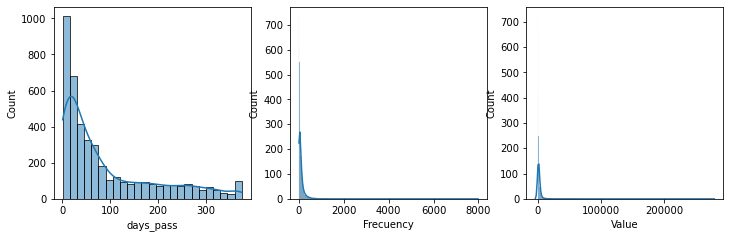

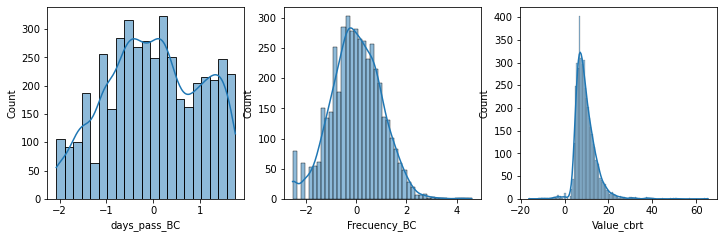

In [59]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
for i, column in enumerate(customers.columns, 1):
    plt.subplot(3,3,i)
    sns.histplot(customers[column],kde=True) 
#with boxcox
fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,12))    
for i, column in enumerate(df_features[["days_pass_BC","Frecuency_BC","Value_cbrt"]],1):
    plt.subplot(3,3,i)
    sns.histplot(df_features[column],kde=True)

In [64]:
#Transform columns

from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Days_pass"] = df_features["days_pass_BC"].values
customers_fix["Frequency"] = df_features["Frecuency_BC"].values
customers_fix["MonetaryValue"] = df_features["Value_cbrt"].values
customers_fix.head()

,Days_pass,Frequency,MonetaryValue
0,1.611173,-2.098072,0.000000
1,-1.797592,1.151346,16.273929
2,0.309053,-0.224316,12.158183
3,-0.645121,0.423978,12.068017
4,1.560964,-0.660498,6.941001


In [66]:
#Normalizing data in order to have a similiar mean and std

from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]
pd.DataFrame(customers_normalized).describe()

[ 0. -0. -0.]
[1. 1. 1.]


,0,1,2
count,4.372000e+03,4.372000e+03,4.372000e+03
mean,1.664890e-17,-6.310394e-17,-2.117093e-16
std,1.000114e+00,1.000114e+00,1.000114e+00
min,-2.072003e+00,-2.527249e+00,-5.176193e+00
25%,-7.130583e-01,-6.604983e-01,-5.961562e-01
50%,3.650514e-03,1.930865e-03,-1.941347e-01
75%,8.409482e-01,6.859230e-01,4.202781e-01
max,1.750433e+00,4.600201e+00,1.115629e+01


In [ ]:
#TO BE CONTINUE...